use focal loss

exp0010 → exp0011

重複しているファイルを消して学習をする

exp0011 → exp0012

augmentation test <br>
aug_spec_mixupを導入し、50%の確率で適用するかしないか

- eca_nfnet_l0 (2 stages training; Start LR 1e-3)- 
convnext_small_fb_in22k_ft_in1k_384 (2 stages training; Start LR 1e-4
- 
convnextv2_tiny_fcmae_ft_in22k_in1k_384 (1 stage training; Start LR 1e-4)

exp1011 specmix upの実験

exp1018 oversampling

exp1019 augmentation test

In [1]:
KAGGLE = True

isTrain = False
isInference = True

if isTrain == False and isInference == True:
    newDir = False
else:
    newDir = True

In [2]:
print(newDir)

False


In [3]:
if KAGGLE == True:
    !pip install /kaggle/input/onnxruntime/humanfriendly-10.0-py2.py3-none-any.whl --no-index --find-links /kaggle/input/onnxruntime
    !pip install /kaggle/input/onnxruntime/coloredlogs-15.0.1-py2.py3-none-any.whl --no-index --find-links /kaggle/input/onnxruntime
    !pip install /kaggle/input/onnxruntime/onnxruntime-1.17.3-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl --no-index --find-links /kaggle/input/onnxruntime

Looking in links: /kaggle/input/onnxruntime
Processing /kaggle/input/onnxruntime/humanfriendly-10.0-py2.py3-none-any.whl
Looking in links: /kaggle/input/onnxruntime
Processing /kaggle/input/onnxruntime/coloredlogs-15.0.1-py2.py3-none-any.whl
Looking in links: /kaggle/input/onnxruntime
Processing /kaggle/input/onnxruntime/onnxruntime-1.17.3-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl


In [4]:
import os
import gc
import sys
import glob
import time
import shutil
import random
import warnings
warnings.simplefilter("ignore")

import wandb

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold, StratifiedGroupKFold

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from torch.cuda import amp
import torch
print(f"pytorch version is {torch.__version__}")
import torch.nn as nn
from torch.cuda import amp

import torchvision
from torchvision.transforms import v2 as transforms

import librosa
import torchaudio
import torchaudio.transforms as audioT

if KAGGLE == False:
    import nnAudio
    from nnAudio import features
    import albumentations
    from audiomentations import Compose, SpecCompose, OneOf, AddGaussianNoise, AddColorNoise
    from audiomentations import TimeStretch, PitchShift, Shift, SpecFrequencyMask, TimeMask
    from audiomentations import Gain, GainTransition
    from torcheval.metrics.functional import multiclass_auroc, multiclass_f1_score, multiclass_precision, multiclass_recall, multilabel_accuracy
if KAGGLE == False:
    from adan_pytorch import Adan
import timm

pytorch version is 2.1.2+cpu


In [5]:
timm.list_models("*ec*")

['eca_botnext26ts_256',
 'eca_halonext26ts',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'eca_nfnet_l2',
 'eca_nfnet_l3',
 'eca_resnet33ts',
 'eca_resnext26ts',
 'eca_vovnet39b',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ecaresnext26t_32x4d',
 'ecaresnext50t_32x4d',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'selecsls42',
 'selecsls42b',
 'selecsls60',
 'selecsls60b',
 'selecsls84']

In [6]:
## decide name
if KAGGLE == False:
    if isTrain == True:
        name = sorted(glob.glob("exp1*.ipynb"))[-1][:-6]
        print(f"filename is {name}")
    else:
        name = "exp1057"
        print(f"filename is {name}")
else:
    name = "exp1057"
    name = f'bird2024{name}'
    print(f"filename is {name}")
trial = "trial1"
p_name = f"BirdCLEF_cv_ver2"


filename is bird2024exp1057


In [7]:
class config:
    if KAGGLE:
        dir = "/kaggle/input/birdclef-2024/"
    else:
        dir = "/mnt/d/kaggle/birdclef-2024/"

    # wave_path = "/mnt/d/kaggle/birdclef-2024/original_waves/second_30/"
    wave_path = "original_waves/second_30/"

    # model_name = 'eca_nfnet_l0'
    model_name = 'tf_efficientnet_b0'

    pool_type = 'avg'

    
    train_duration = 30 ##学習に使うデータの秒数
    slice_duration = 5 ##実際にSTFTをして食わせるデータのサイズ

    test_duration = 5

    train_drop_duration = 1
    
    ###spectrogram parameters
    sr = 32000
    fmin = 20
    fmax = 15000

    n_mels = 128
    n_fft = n_mels*8
    size_x = 512
    
    hop_length = int(sr*slice_duration / size_x)
    test_hop_length = int(sr*test_duration / size_x)
    
    bins_per_octave = 12

    nfolds = 5
    inference_folds = [4]
    
    enable_amp = True
    train_batchsize = 32
    valid_batchsize = 1

    # loss_type = "BCEWithLogitsLoss"
    loss_type = "BCEFocalLoss"

    lr = 1.0e-03 #for tf_efficientnet_b0
    # lr = 1.0e-04 #for movilenet
    # lr = 1.0e-05 #for movilenet

    optimizer='adan'
    # optimizer='adamW'
    weight_decay = 1.0e-02
    es_patience =  5
    deterministic = True
    enable_amp = True

    max_epoch = 9
    aug_epoch = 6
    

    useSecondary =True
    secondary_label_value = 0.5
    oversample =False
    oversample_threthold = 60
    
    seed = 42

    wandb = True

    ###augmentation flags
    aug_noise            = 0.
    aug_gain             = 0.0
    aug_wave_pitchshift  = 0.0#効果はあるので入れたいが、重いので実験中は使わない
    aug_wave_shift       = 0.

    aug_spec_xymasking   = 0.
    aug_spec_coarsedrop  = 0.
    aug_spec_hflip       = 0.

    ##mixup param
    aug_wave_mixup       = 1.0
    aug_spec_mixup       = 0.0
    aug_spec_mixup_prob  = 0.5 #specmixup++をさせる確率
    alpha=0.95

    smoothing_value      = 0.0
    # spec_mix_mask_percent = 20
    
cfg = config()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


# device = torch.device('cpu')

print(device)

cpu


## augmentation tools

In [8]:
#https://iver56.github.io/audiomentations/waveform_transforms/add_color_noise/

In [9]:
if isTrain== True:

    normal_augment = Compose([
        OneOf([
            Gain(min_gain_in_db=-15, max_gain_in_db=15, p=1.0),
            GainTransition(min_gain_in_db=-24.0, max_gain_in_db=6.0,
                           min_duration=0.2, max_duration=6.0,  p=1.0)
        ], p=cfg.aug_gain),
        
        OneOf([
            AddGaussianNoise(p=1),
            AddColorNoise(p=1, min_snr_db=5, max_snr_db=20, min_f_decay=-3.01, max_f_decay=-3.01)
        ],p=cfg.aug_noise),
        # OneOf([
        #     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=1),
        #     AddColorNoise(p=1, max_f_decay=-3.01, min_snr_db=5, max_snr_db=20, n_fft=cfg.n_fft)
        # ],p=cfg.aug_noise),
    
        PitchShift(min_semitones=-1, max_semitones=1, p=cfg.aug_wave_pitchshift),
        Shift(p=cfg.aug_wave_shift)
    ])
    alb_transform = [
        ### num_masks_x=1, num_masks_y=1 will change
        albumentations.XYMasking(num_masks_x=2, num_masks_y=1, 
                                 mask_x_length=cfg.size_x//30, mask_y_length=cfg.n_mels//30,
                                 fill_value=0, mask_fill_value=0, p=cfg.aug_spec_xymasking),
        albumentations.CoarseDropout(fill_value=0, min_holes=20, max_holes=50, p=cfg.aug_spec_coarsedrop),
        albumentations.HorizontalFlip(p=cfg.aug_spec_hflip)    
    ]
    albumentations_augment = albumentations.Compose(alb_transform)

In [10]:
def mixup(data, targets, alpha, mode="same_wave"):
    
    if mode == "same_wave":
        data = torch.tensor(data)
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        # shuffled_targets = targets[indices]
        #print(indices)
        lam = np.random.beta(alpha, alpha)
        #print(lam)
        new_data = data * lam + shuffled_data * (1 - lam)
        # new_targets = targets * lam + shuffled_targets * (1 - lam)
        return new_data.numpy()
        
    elif mode == "other_wave":
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_targets = targets[indices]
    
        lam = np.random.beta(alpha, alpha)
        new_data = data * lam + shuffled_data * (1 - lam)
        new_targets = targets * lam + shuffled_targets * (1 - lam)
    
        return new_data, new_targets

In [11]:
if isTrain== True:
    spec_xymasking = albumentations.XYMasking(num_masks_x=2, num_masks_y=1, 
                                              mask_x_length=cfg.size_x // 10, mask_y_length=cfg.n_mels // 10,
                                              fill_value=0, mask_fill_value=0, p=1)

def spec_mixup(data, targets):
    type = data.dtype

    indices = torch.randperm(data.size(0))
    # print(indices)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    ##masking
    data = np.array(data)
    data_transposed = np.transpose(data, (2, 3, 1, 0))
    data_transposed = spec_xymasking(image=data_transposed)["image"]
    data_transposed = np.transpose(data_transposed, (3, 2, 0, 1))  

    ##masking した場所を取り出す
    diff = data - data_transposed
    mask = (diff != 0).astype(int)

    ##mask箇所を、ほかのデータから取り出す
    shuffled_data_masked = (shuffled_data * mask)

    ##mixup
    new_data = torch.tensor(data_transposed, dtype=type) + torch.tensor(shuffled_data_masked, dtype=type)

    #lamはmask量で決める
    # print(data.size(0))
    lam = mask.sum() / len(data) / (cfg.n_mels*cfg.size_x)
    # print(lam)
    new_targets = targets * (1-lam) + shuffled_targets *lam

    return new_data, new_targets

In [12]:
spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
    # normalized=True
).to(device)

valid_spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.test_hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
    # normalized=True
).to(device)

test_spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.test_hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
    # normalized=True
).cpu()

In [13]:
print(newDir)

False


In [14]:
if KAGGLE == False:
    if cfg.wandb == True:
        wandb.login(key="1def2aa62f171b4a95415cc2ad76b5eb1bb37b41")

    if newDir == True:
        new_dir_path_recursive = f"{name}/checkpoint"
    
        os.makedirs(new_dir_path_recursive, exist_ok=True)
        shutil.rmtree(new_dir_path_recursive)
        os.makedirs(new_dir_path_recursive, exist_ok=True)

---

# csv preprocessing

In [15]:
sample_submission = pd.read_csv(cfg.dir+"sample_submission.csv")
LABELS = list(sample_submission.set_index("row_id").columns)
LABELS[:5]

['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2']

In [16]:
sample_submission

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [17]:
# if isTrain:
if KAGGLE == False:
    train_csv = pd.read_csv(cfg.dir+"train_eda.csv")
    train_csv["fileID"] = train_csv["filename"].map(lambda x:x.split("/")[1][:-4])
    train_csv.head(2)
else:
    train_csv = pd.read_csv(cfg.dir+"train_metadata.csv")

<Axes: xlabel='len_new_target'>

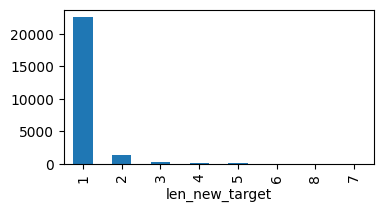

In [18]:
import ast
train_csv['new_target'] = train_csv['primary_label'] + ' ' + train_csv['secondary_labels'].map(lambda x: ' '.join(ast.literal_eval(x)))
train_csv['len_new_target'] =train_csv['new_target'].map(lambda x: len(x.split()))
train_csv["len_new_target"].value_counts().plot(kind="bar", figsize=(4,2))

In [19]:
train_csv["filename_tmp"] = train_csv["filename"].map(lambda x:x.split("/")[1][:-4])

In [20]:
duplicated_filenames = train_csv["filename_tmp"].value_counts()[train_csv["filename_tmp"].value_counts() > 1].index

In [21]:
duplicated_filenames

Index(['XC503389', 'XC306398', 'XC514027', 'XC447036', 'XC522123', 'XC403621',
       'XC574864', 'XC184466', 'XC659329', 'XC467373', 'XC209564', 'XC581045',
       'XC239509', 'XC209549', 'XC163901', 'XC674522', 'XC208795', 'XC208794',
       'XC209203'],
      dtype='object', name='filename_tmp')

In [22]:
train_csv = train_csv[~train_csv["filename_tmp"].isin(duplicated_filenames)]
train_csv = train_csv.reset_index(drop=True)

# Dataset

In [23]:
class BirdCLEF_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=False, mode='train'):
        if mode == 'train':
            self.df = df.reset_index(drop=True)
        elif mode == 'valid':
            self.df = df.reset_index(drop=True)
        else:
            self.df = df
        self.mode = mode
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.df)

    def normalize(self, x):
        valid_values = x[x != float('-inf')]
        mean_value = np.mean(valid_values)
        x[x == float('-inf')] = mean_value
        # x[x == float('-inf')] = 0

        x = x - x.min()
        x = x / x.max()
        return x

    def wave_tile_and_cutoff(self, data):
        ### ---PREPROCESS wave length to train duration & slice duration-----
        drop_duration = cfg.sr*cfg.train_drop_duration
        use_duration  = cfg.sr*cfg.train_duration
        
        if len(data[0]) > drop_duration: #最初の1秒を捨てる
            data = data[:,drop_duration:]

        if len(data[0]) < use_duration: #30秒に満たない場合はタイルする
            iter = 1 + (use_duration) // len(data[0])
            data = np.tile(data, (1, iter))

        data = data[:,:use_duration]
        return data

    def label_smoothing(self, idx, target):
    
        secondary_target = target * cfg.secondary_label_value
    
        out_of_target_noise_intensity = cfg.smoothing_value/(len(LABELS)-1) #該当label以外に、smootiong_valueを分散させる
        out_of_target_noise_array = torch.ones(target.shape) * out_of_target_noise_intensity
        
        secondary_target_with_noise = secondary_target + out_of_target_noise_array
        secondary_target_with_noise = torch.clip(secondary_target_with_noise, min=0, max=cfg.secondary_label_value)
    
        primary_target = np.isin(LABELS, self.df.loc[idx, "primary_label"]).astype(int)
        primary_target = torch.tensor(primary_target, dtype=torch.float32)

        primary_and_secondary_target_with_noise = primary_target + secondary_target_with_noise
        new_target = torch.clip(primary_and_secondary_target_with_noise, min=0, max=1)
    
        new_target = new_target - primary_target * cfg.smoothing_value
    
        return new_target

    
    def __getitem__(self, idx):

        if self.mode == 'train':

            ### ------------------READ DATA  ------------------------------------
            if cfg.useSecondary == True:
                target = np.isin(LABELS, self.df.loc[idx, "new_target"].split()).astype(int)
            else:
                target = np.isin(LABELS, self.df.loc[idx, "primary_label"].split()).astype(int)
            target = torch.tensor(target, dtype=torch.float32)
            ### ------------------label smoothing  --------------------------
            target = self.label_smoothing(idx, target)
            
            fileID = self.df.loc[idx, 'fileID'] #filename : ****/****.ogg
            
            path = f"{cfg.wave_path}{fileID}.npy"
            wave = np.load(path)
            ### -----------------------------------------------------------------

            # ---PREPROCESS wave length to train duration & slice duration-------
            wave = self.wave_tile_and_cutoff(data=wave)

            
            input_duration = cfg.sr * cfg.slice_duration
            # middle_shift = cfg.sr * cfg.train_duration // 2 
            
            if self.augmentation == True:
                ### ------------------wave time mixup  --------------------------
                if cfg.aug_wave_mixup > np.random.random(): #同じwave内でmixupをする
                    #train_duration -> slice_duration
                    wave_reshape = wave.reshape(-1, input_duration)
                    wave = mixup(data=wave_reshape, targets=target, alpha=cfg.alpha, mode="same_wave")
                    wave = wave[:1,:]
                else:
                    wave = wave[:, :input_duration]
                
                ### ------------------wave augmentation  ------------------------
                wave = normal_augment(samples=wave, sample_rate=cfg.sr)

                ### ------------------MAKE SPECTROGRAM  -------------------------
                wave = torch.tensor(wave).to(device)
                mel_spec = spec_layer(wave)
                mel_spec = np.array(mel_spec.cpu())

                mel_spec = np.log(mel_spec)
                for i in range(len(mel_spec)):
                    mel_spec[i] = self.normalize(mel_spec[i])
                mel_spec = torch.tensor(mel_spec)
                mel_spec = mel_spec[:,:,:cfg.size_x]

                ### ------------------spec augmentation  ------------------------
                mel_spec = np.array(mel_spec.cpu())
                mel_spec = np.transpose(mel_spec, (1, 2, 0))                
                mel_spec = albumentations_augment(image=mel_spec)["image"]
                mel_spec = np.transpose(mel_spec, (2, 0, 1))

                # ### ------------------label smoothing  --------------------------
                # target = self.label_smoothing(idx, target)
                
            else:
                wave = wave[:, :input_duration]
                
                ### ------------------MAKE SPECTROGRAM  -------------------------
                wave = torch.tensor(wave).to(device)
                mel_spec = spec_layer(wave)
                mel_spec = np.array(mel_spec.cpu())

                mel_spec = np.log(mel_spec)

                for i in range(len(mel_spec)):
                    mel_spec[i] = self.normalize(mel_spec[i])
                    

                mel_spec = torch.tensor(mel_spec)
                mel_spec = mel_spec[:,:,:cfg.size_x]

            
            mel_spec = torch.tensor(mel_spec)

            
            return mel_spec, target

        elif self.mode == 'valid':
            
            ### ------------------READ DATA  ------------------------------------
            if cfg.useSecondary == True:
                target = np.isin(LABELS, self.df.loc[idx, "new_target"].split()).astype(int)
            else:
                target = np.isin(LABELS, self.df.loc[idx, "primary_target"].split()).astype(int)
            target = torch.tensor(target, dtype=torch.float32)
            
            fileID = self.df.loc[idx, 'fileID'] #filename : ****/****.ogg
            
            path = f"{cfg.wave_path}{fileID}.npy"
            wave = np.load(path)
            ### -----------------------------------------------------------------

            # ---PREPROCESS wave length to train duration & slice duration-------
            wave = self.wave_tile_and_cutoff(data=wave)

            input_duration = cfg.sr*cfg.test_duration
            wave_reshape = wave.reshape(-1, input_duration)

            wave_reshape = torch.tensor(wave_reshape).to(device)
            mel_specs = valid_spec_layer(wave_reshape)
            mel_specs = mel_specs.cpu().numpy()

            mel_specs = np.log(mel_specs)
            for i in range(len(mel_specs)):
                mel_specs[i] = self.normalize(mel_specs[i])
            mel_specs = torch.tensor(mel_specs)
            
            mel_specs = mel_specs[:,:,:cfg.size_x]

            targets = torch.tile(target, dims=(mel_specs.shape[0],1))
            return mel_specs, targets

        ###---------------------------------------------------------------------------------------------------------------------
        elif self.mode == 'test':

            filepath = self.df[idx]
            wave, _  = torchaudio.load(filepath)
            wave = wave[:,:60*4*32000]

            wave_reshaped = wave.reshape(-1, 1, cfg.test_duration*cfg.sr)
            
            mel_spec = test_spec_layer(wave_reshaped)
            mel_spec = np.log(mel_spec)

            mel_spec = np.array(mel_spec)
            for i in range(len(mel_spec)):
                mel_spec[i] = self.normalize(mel_spec[i])
            mel_spec = torch.tensor(mel_spec)

            mel_spec = mel_spec[:,:,:cfg.size_x]
            return mel_spec

        elif self.mode == 'clean':

            filepath = self.df[idx]
            wave, _  = torchaudio.load(filepath)

            wave = wave[:, :6*cfg.test_duration*cfg.sr]

            chunk_length = len(wave[0]) // (cfg.test_duration*cfg.sr)
            
            wave = wave[:,:chunk_length*cfg.test_duration*cfg.sr]

            wave_reshaped = wave.reshape(-1, 1, cfg.test_duration*cfg.sr)
            
            mel_spec = test_spec_layer(wave_reshaped)
            mel_spec = np.log(mel_spec)

            mel_spec = np.array(mel_spec)
            for i in range(len(mel_spec)):
                mel_spec[i] = self.normalize(mel_spec[i])
            mel_spec = torch.tensor(mel_spec)

            return mel_spec, filepath

In [24]:
if isTrain:
    print("train data")
    dataset = BirdCLEF_Dataset(df=train_csv, augmentation=True,  mode="train")
    data, target = dataset[270]
    fig, ax = plt.subplots(figsize=(6,4))
    plt.imshow(data[0], cmap="jet", origin="lower")
    plt.show()
    
    print("validation data")
    dataset = BirdCLEF_Dataset(df=train_csv, augmentation=True,  mode="valid")
    data, target = dataset[270]
    fig, axes = plt.subplots(figsize=(12,8), nrows=len(data), tight_layout=True)
    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(data[idx], cmap="jet", origin="lower")

In [25]:
#break

# Model

## poolings

In [26]:
# class GeM(torch.nn.Module):
#     def __init__(self, p=3, eps=1e-6):
#         super(GeM, self).__init__()
#         self.p = torch.nn.Parameter(torch.ones(1) * p)
#         self.eps = eps

#     def forward(self, x):
#         bs, ch, h, w = x.shape
#         x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1.0 / self.p)
#         x = x.view(bs, ch)
#         return x

### simple efficientnet SEDmodel

In [27]:
class BirdModel(torch.nn.Module):
    def __init__(self, model_name, pretrained, in_channels, num_classes, pool="default"):
        super().__init__()

        self.pool = pool
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        if pool == "default":
            self.backbone = timm.create_model(
                model_name=model_name, pretrained=pretrained,
                num_classes=0, in_chans=3)
        else:
            self.backbone = timm.create_model(
                model_name=model_name, pretrained=pretrained,
                num_classes=0, in_chans=3, global_pool="")

        in_features = self.backbone.num_features


        # self.pooling = torch.nn.MaxPool2d()
        # self.pooling = torch.nn.AvgPool2d()
        self.max_pooling = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1),
                                               torch.nn.Flatten(start_dim=1, end_dim=-1))
        self.avg_pooling = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(1),
                                               torch.nn.Flatten(start_dim=1, end_dim=-1))
        self.both_pooling_neck = torch.nn.Sequential(torch.nn.BatchNorm1d(2*in_features),
                                                     torch.nn.Linear(in_features=2*in_features, out_features=in_features))
        
        self.head = torch.nn.Sequential(
            torch.nn.BatchNorm1d(in_features),
            torch.nn.Linear(in_features=in_features, out_features=256),
            torch.nn.Hardswish(inplace=True),torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=256, out_features=len(LABELS))  
        )



        self.active = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.expand(-1, 3, -1, -1)
        x = self.normalize(x)
        x = self.backbone(x)

        if self.pool == "max":
            x = self.max_pooling(x)
        elif self.pool == "avg":
            x = self.avg_pooling(x)
        elif self.pool == "both":
            x_max = self.max_pooling(x)
            x_avg = self.avg_pooling(x)
            x = x_max + x_avg
            # x = torch.cat([x_max, x_avg], dim=1)
            # x = self.both_pooling_neck(x)
            
        x = self.head(x)
        # x = self.active(x)
        return x

In [28]:
# if isTrain:
#     model = BirdModel(model_name=cfg.model_name, pretrained=True, in_channels=3, num_classes=len(LABELS)).to(device)
#     inp = torch.rand([4, 1, 256, 401])
#     tmp = model.forward(inp.to(device))
#     print(tmp.shape)

### PANNs

In [29]:
# class PANNsCNN14Att(nn.Module):
#     def __init__(self, sample_rate: int, window_size: int, hop_size: int,
#                  mel_bins: int, fmin: int, fmax: int, classes_num: int):
#         super().__init__()

#         self.spec_layer = nnAudio.features.MelSpectrogram(
#             sr=cfg.sr, hop_length=cfg.hop_length, fmin=cfg.fmin, fmax=cfg.fmax, 
#             n_fft=cfg.n_fft, n_mels=cfg.n_mels, 
#             window='hann',center=True, pad_mode='reflect', trainable_mel=True, trainable_STFT=True).cuda()
        
#         self.cqt_layer = nnAudio.features.CQT(
#             sr=cfg.sr, hop_length=cfg.hop_length, fmin=cfg.fmin, fmax=cfg.fmax,
#             bins_per_octave=cfg.bins_per_octave, 
#             window='hann', pad_mode='reflect', trainable=True).cuda()
        
#         self.backbone = timm.create_model(
#             model_name=model_name, pretrained=pretrained,
#             num_classes=len(LABELS), in_chans=1)
        

#         # Spec augmenter
#         self.spec_augmenter = SpecAugmentation(
#             time_drop_width=64,
#             time_stripes_num=2,
#             freq_drop_width=8,
#             freq_stripes_num=2)

#         self.bn0 = nn.BatchNorm2d(mel_bins)

#         self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
#         self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
#         self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
#         self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
#         self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
#         self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

#         self.fc1 = nn.Linear(2048, 2048, bias=True)
#         self.att_block = AttBlock(2048, classes_num, activation='sigmoid')

#         self.init_weight()

#     def init_weight(self):
#         init_bn(self.bn0)
#         init_layer(self.fc1)
        
#     def cnn_feature_extractor(self, x):
#         x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
#         x = F.dropout(x, p=0.2, training=self.training)
#         return x
    
#     def preprocess(self, input, mixup_lambda=None):
#         # t1 = time.time()
#         x = self.spectrogram_extractor(input)  # (batch_size, 1, time_steps, freq_bins)
#         x = self.logmel_extractor(x)  # (batch_size, 1, time_steps, mel_bins)

#         frames_num = x.shape[2]

#         x = x.transpose(1, 3)
#         x = self.bn0(x)
#         x = x.transpose(1, 3)

#         if self.training:
#             x = self.spec_augmenter(x)

#         # Mixup on spectrogram
#         if self.training and mixup_lambda is not None:
#             x = do_mixup(x, mixup_lambda)
#         return x, frames_num
        

#     def forward(self, input, mixup_lambda=None):
#         """
#         Input: (batch_size, data_length)"""
#         x, frames_num = self.preprocess(input, mixup_lambda=mixup_lambda)

#         # Output shape (batch size, channels, time, frequency)
#         x = self.cnn_feature_extractor(x)
        
#         # Aggregate in frequency axis
#         x = torch.mean(x, dim=3)

#         x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
#         x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
#         x = x1 + x2

#         x = F.dropout(x, p=0.5, training=self.training)
#         x = x.transpose(1, 2)
#         x = F.relu_(self.fc1(x))
#         x = x.transpose(1, 2)
#         x = F.dropout(x, p=0.5, training=self.training)

#         (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
#         segmentwise_output = segmentwise_output.transpose(1, 2)

#         # Get framewise output
#         framewise_output = interpolate(segmentwise_output,
#                                        self.interpolate_ratio)
#         framewise_output = pad_framewise_output(framewise_output, frames_num)

#         output_dict = {
#             'framewise_output': framewise_output,
#             'clipwise_output': clipwise_output
#         }

#         return output_dict

# get fold

In [30]:
# if isTrain:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
skf = StratifiedKFold(n_splits=cfg.nfolds, shuffle=True, random_state=cfg.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_csv, train_csv['primary_label'])):
    train_csv.loc[valid_index, 'fold'] = int(fold)

In [31]:
if isTrain:
    train_csv.groupby("fold", as_index=False)["primary_label"].value_counts()

# Trainer Utils

## set seed function

In [32]:
def set_random_seed(seed: int = 42, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

## INIT

### Loss

In [33]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)

        

        tmp = targets * self.alpha * (1. - probas)**self.gamma * bce_loss
        smp = (1. - targets) * probas**self.gamma * bce_loss
        
        loss = tmp + smp
        loss = loss.mean()
        return loss

In [34]:
def initialization():
    model = BirdModel(model_name=cfg.model_name, pretrained=True, in_channels=3, num_classes=len(LABELS), pool=cfg.pool_type)
    
    if cfg.optimizer=='adan':
        optimizer = Adan(model.parameters(), lr=cfg.lr, betas=(0.02, 0.08, 0.01), weight_decay=cfg.weight_decay)
    else:
        optimizer = torch.optim.AdamW(params=model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer, epochs=cfg.max_epoch,
        pct_start=0.0, steps_per_epoch=len(train_dataloader),
        max_lr=cfg.lr, div_factor=25, final_div_factor=4.0e-01
    )
    
    scaler = amp.GradScaler(enabled=cfg.enable_amp)
    if cfg.loss_type == "BCEWithLogitsLoss":
        loss_func = torch.nn.BCEWithLogitsLoss()
    elif cfg.loss_type == "BCEFocalLoss":
        loss_func = BCEFocalLoss(alpha=1)
    
    
    
    # loss_func = torch.nn.CrossEntropyLoss()
    # loss_func = torch.nn.BCELoss()

    return model.to(device), optimizer, scheduler, scaler, loss_func.to(device)

In [35]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score

## trainer function

In [36]:
def train_one_loop(model, optimizer, scaler, scheduler, dataloader, loss_fn):
    trainloss = 0; model.train()

    count = 0
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[train]")):
        # label = label.reshape(-1, len(LABELS))
        
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with amp.autocast(cfg.enable_amp, dtype=torch.bfloat16):
        # with amp.autocast(cfg.enable_amp):
            pred = model.forward(data)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        
        trainloss += loss.item()
        # print(idx, loss.item())
        # if cfg.wandb == True:
        #     wandb.log({f"train_loss": loss.item(), f"lr":scheduler.get_lr()[0]})
        del data, label, loss
        count += 1
        # if count == 300:
        # break
    trainloss /= len(dataloader)
    if cfg.wandb == True:
        wandb.log({f"train_loss": trainloss, f"lr":scheduler.get_lr()[0]})
    return model, optimizer, scaler, scheduler, trainloss


def mixup_one_loop(model, optimizer, scaler, scheduler, dataloader, loss_fn):
    trainloss = 0; model.train()

    count = 0
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[train]")):
        if np.random.random()>cfg.aug_spec_mixup_prob:
            data, label = mixup(data=data, targets=label, alpha=cfg.alpha, mode="other_wave")
        else:
            data, label = spec_mixup(data=data, targets=label)
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with amp.autocast(cfg.enable_amp, dtype=torch.bfloat16):
        # with amp.autocast(cfg.enable_amp):
            pred = model.forward(data)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        
        trainloss += loss.item()
        # print(idx, loss.item())
        # if cfg.wandb == True:
        #     wandb.log({f"lr":scheduler.get_lr()[0]})
        del data, label, loss
        count += 1
        # if count == 300:
        # break
    trainloss /= len(dataloader)
    if cfg.wandb == True:
        wandb.log({f"train_loss": trainloss, f"lr":scheduler.get_lr()[0]})
    return model, optimizer, scaler, scheduler, trainloss


def evaluate_validation(model, dataloader, loss_fn):
    validloss=0
    model.eval()

    preds, trues, targets = [], [], []
    
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[valid]")):
        # label = label.reshape(-1, len(LABELS))

        d = data[0].unsqueeze(1)
        label = label[0]
        
        d = d.to(device)
        # with amp.autocast(cfg.enable_amp):
        pred = model.forward(d)

        preds.extend(pred.detach().cpu())
        trues.extend(label)
        targets.extend(label.argmax(axis=1))
        
    #======================== metrics ========================#
    # y_preds = torch.stack(preds)
    t = torch.stack(preds)
    t = torch.sigmoid(t)
    targets = torch.tensor(targets)
    y_trues = torch.stack(trues)


    validloss = loss_fn(torch.stack(preds), torch.stack(trues))
    #     # print(idx, loss)
    #     # wandb.log({"valid_loss": loss})

    # validloss /= len(dataloader)
    
    # sk_f1 = metrics.f1_score(np.array(y_trues), np.array(t), average="micro")
    sk_f1_30 = metrics.f1_score(np.array(y_trues), np.array(t) > 0.30, average="micro")
    sk_f1_50 = metrics.f1_score(np.array(y_trues), np.array(t) > 0.50, average="micro")
    
    auc = multiclass_auroc(input=t, target=targets, num_classes=len(LABELS),
                           average="macro").item()

    # auc_micro = multiclass_auroc(input=t, target=targets, num_classes=len(LABELS),
    #                        average="none").item()

    prec = multiclass_precision(input=t, target=targets, num_classes=len(LABELS),
                           average="macro").item()
    # rec = multiclass_recall(input=t, target=targets, num_classes=len(LABELS),
    #                        average="macro").item()
    
    # acc = multilabel_accuracy(input=t, target=targets).item()

    f1 = multiclass_f1_score(input=t, target=torch.tensor(targets), num_classes=len(LABELS),
                             average="micro").item()

    f1_macro = multiclass_f1_score(input=t, target=torch.tensor(targets), num_classes=len(LABELS),
                             average="macro").item()

    t_03 = (t>0.3).int()
    t_03 = torch.tensor(t_03, dtype=torch.int64)
    f1_03 = multiclass_f1_score(input=t_03, target=torch.tensor(targets), num_classes=len(LABELS), 
                                average="micro").item()

    t_05 = (t>0.5).int()
    t_05 = torch.tensor(t_05, dtype=torch.int64)
    f1_05 = multiclass_f1_score(input=t_05, target=torch.tensor(targets), num_classes=len(LABELS), 
                                average="micro").item()

    if cfg.wandb == True:
        wandb.log({f"valid_loss": validloss,
                   f"AUC":auc,
                   # "auc_micro":auc_micro,
                   "precision":prec, 
                   # "recall":rec, 
                   # "accuracy":acc,
                   f"F1":f1,
                   "F1_macro":f1_macro,
                   f"F1 30%":f1_03,
                   f"F1 50%":f1_05})
    return validloss, auc, f1, f1_03, f1_05, sk_f1_30, sk_f1_50

## training

In [37]:
if isTrain == True:
    tmp_params = dict(vars(config))
    del tmp_params['__module__'],tmp_params['__dict__'],tmp_params['__weakref__'],tmp_params['__doc__']

In [38]:
# cfg.wandb = False

### oversampling

In [39]:
def get_oversampled_df(df):
    
    new_df = [df]

    low_sample_birds = df["primary_label"].value_counts()[df["primary_label"].value_counts() < cfg.oversample_threthold].index
    for bird in low_sample_birds:
        tmp = df[df["primary_label"] == bird]
        data_num = len(tmp)
    
        tiles = 1 + cfg.oversample_threthold // data_num
    
        tile_df = []
        for i in range(tiles):
            tile_df.append(tmp)
    
        tiled_df = pd.concat(tile_df)
        piece = tiled_df[data_num:cfg.oversample_threthold]
        new_df.append(piece)
    
    return pd.concat(new_df)

### in train

In [40]:
if isTrain == True:
    set_random_seed(seed=42)
    
    
    if cfg.wandb == True:
        wandb.init(project=p_name, name=f"{name}",
                   config=tmp_params)
        
    # for fold in range(cfg.nfolds):
    for fold in cfg.inference_folds:
        train_ = train_csv.loc[train_csv["fold"]!=fold]

        if cfg.oversample == True:
            train = get_oversampled_df(df=train_)
        else:
            train = train_
        
        augme_dataset = BirdCLEF_Dataset(df=train, augmentation=True, mode='train')
        augme_dataloader = torch.utils.data.DataLoader(dataset=augme_dataset, batch_size=cfg.train_batchsize, shuffle=True)

        train_dataset = BirdCLEF_Dataset(df=train, augmentation=False, mode='train')
        train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=cfg.train_batchsize, shuffle=True)
        
        valid = train_csv.loc[train_csv["fold"]==fold]
        valid_dataset = BirdCLEF_Dataset(df=valid, augmentation=False, mode='valid')
        valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=cfg.valid_batchsize, shuffle=False)
    
        model, optimizer, scheduler, scaler, loss_func =  initialization()
    
    
        best_f1 = 0
        best_auc = 0
        best_loss = 1.00000
        for e in range(cfg.max_epoch):
            start_time = time.time()
            if e < cfg.aug_epoch:
                if cfg.aug_spec_mixup > np.random.random():
                    model, optimizer, scaler, shcheduler, train_loss = mixup_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=augme_dataloader, loss_fn=loss_func)
                else:
                    model, optimizer, scaler, shcheduler, train_loss = train_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=augme_dataloader, loss_fn=loss_func)

            else:
                model, optimizer, scaler, shcheduler, train_loss = train_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=train_dataloader, loss_fn=loss_func)
            
            valid_loss, auc, f1, f1_03, f1_05, sk_f1_30, sk_f1_50 = evaluate_validation(model=model, dataloader=valid_dataloader, loss_fn=loss_func)
            # print(f"epoch {e} , train_loss is {train_loss}, valid_loss is {valid_loss}")
            
            if best_loss > valid_loss:
                end_time = time.time()
                print(f"[epoch {str(e).zfill(2)}] AUC{auc: .4f}, F1{f1: .4f}, F1_03{f1_03: .4f}, F1_05{f1_05: .4f}")
                print(f"[epoch {str(e).zfill(2)}] SKF1_03{sk_f1_30: .4f}, SKF1_05{sk_f1_50: .4f}")
                print(f"[epoch {str(e).zfill(2)}] valid_loss {valid_loss: .6f}")
                print(f"[epoch {str(e).zfill(2)}] update loss {best_loss: .6f} --> {valid_loss: .6f} {(end_time - start_time): .1f}[s]")
                print(f"[epoch {str(e).zfill(2)}] update auc score {best_auc: .6f} --> {auc: .6f} {(end_time - start_time): .1f}[s]")
                model_name = f'{name}/checkpoint/fold_{fold}_snapshot_epoch_{str(e).zfill(2)}.pth'
                best_model = model
                best_loss = valid_loss
                best_auc = auc
                best_f1 = f1
            else:
                end_time = time.time()
                print(f"[epoch {str(e).zfill(2)}] NOT update loss {best_loss: .6f} <-- {valid_loss: .6f} {(end_time - start_time): .1f}[s]")
                print(f"[epoch {str(e).zfill(2)}] NOT update score {best_auc: .6f} <-- {auc: .6f} {(end_time - start_time): .1f}[s]")

        if cfg.wandb == True:
            wandb.log({f"best_loss": best_loss,
                       f"best_f1": best_f1,
                       f"best_auc":best_auc})

        torch.save(best_model.state_dict(), model_name)
        
        del model, best_model
        gc.collect()
        torch.cuda.empty_cache()
        print("--")
        # break

# simple cv

In [41]:
# if isTrain == True:
#     print(f"fold cv : {cross_validation.values()}")
#     print(f"cv : {round (torch.tensor(list(cross_validation.values())).mean().item(), 5 ) }")

# inference

## load models

In [42]:
models = dict()
models_names = dict()
# for fold in range(cfg.nfolds):
for fold in cfg.inference_folds:
    if KAGGLE == True:
        bestmodel_path = sorted(glob.glob(f"/kaggle/input/{name}/checkpoint/fold_{fold}*.pth"))[-1]
    else:
        bestmodel_path = sorted(glob.glob(f"{name}/checkpoint/fold_{fold}*.pth"))[-1]
    print(bestmodel_path)
    model = BirdModel(model_name=cfg.model_name, pretrained=False, in_channels=1, num_classes=len(LABELS))
    model.load_state_dict(torch.load(bestmodel_path, map_location=torch.device('cpu')))
    model = model.eval()
    models[fold] = model

    models_names[fold] = bestmodel_path.split(".")[0]+".onnx"
    print(models_names[fold])

/kaggle/input/bird2024exp1057/checkpoint/fold_4_snapshot_epoch_04.pth
/kaggle/input/bird2024exp1057/checkpoint/fold_4_snapshot_epoch_04.onnx


In [43]:
if KAGGLE == True:
    test_audio_dir = f"{cfg.dir}test_soundscapes/"
    file_list = glob.glob(test_audio_dir+"*.ogg")
    file_list = sorted(file_list)

if KAGGLE == False:
    test_audio_dir = f"{cfg.dir}unlabeled_soundscapes/"
    file_list = glob.glob(test_audio_dir+"*.ogg")
    file_list = sorted(file_list)[:3]

In [44]:
test_dataset = BirdCLEF_Dataset(df=file_list, mode="test")
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=1, 
                                              shuffle=False)

In [45]:
if KAGGLE == False:
    print(test_dataset[0].shape)

# ONNX

## set onnx config

In [46]:
input_tensor = torch.randn((48, 1, cfg.n_mels, cfg.size_x+1))  # input shape
output_names=['output']
input_names=["x"]

## export onnx model

In [47]:
if KAGGLE == False:
    # for fold in range(cfg.nfolds):
    for fold in cfg.inference_folds:
        torch.onnx.export(model=models[fold].eval(),args=(input_tensor), 
                          input_names=input_names, output_names=output_names,f=models_names[fold])


## model convert from pytorch to onnx

In [48]:
import onnx
import onnxruntime as ort

In [49]:
# models_names = []
models_names = dict()
# for fold in range(cfg.nfolds):
for fold in cfg.inference_folds:
    if KAGGLE == True:
        onnxmodel_path = sorted(glob.glob(f"/kaggle/input/{name}/checkpoint/fold_{fold}*.onnx"))[-1]
    else:
        onnxmodel_path = sorted(glob.glob(f"{name}/checkpoint/fold_{fold}*.onnx"))[-1]
    print(onnxmodel_path)
#     models_names.append(onnxmodel_path)
    models_names[fold] = onnxmodel_path

/kaggle/input/bird2024exp1057/checkpoint/fold_4_snapshot_epoch_04.onnx


In [50]:
onnx_sessions = dict()
# for fold in range(cfg.nfolds):
for fold in cfg.inference_folds:

    onnx_model = onnx.load(models_names[fold])
    onnx_model_graph = onnx_model.graph
    onnx_session = ort.InferenceSession(onnx_model.SerializeToString())

    onnx_sessions[fold] = onnx_session

In [51]:
# outputs = onnx_session.run(output_names, {input_names[0]: test_dataset[0].numpy()})[0]

In [52]:
start_time = time.time()

predictions = []
for data in tqdm(test_dataloader):
    
    preds = []
    
#     for fold, session in enumerate(onnx_sessions):
    for fold in cfg.inference_folds:
        session = onnx_sessions[fold]
        pred = session.run(output_names, {input_names[0]: data[0].numpy()})[0]
        
        pred = torch.sigmoid(torch.tensor(pred))
        preds.append(pred)
    preds_per_batch = torch.stack(preds, axis=0).mean(axis=0)
    
    predictions.extend(preds_per_batch)
    
if len(predictions)>0:
    predictions = torch.stack(predictions)
else:
    predictions = predictions
end_time = time.time()
use_time = end_time - start_time

0it [00:00, ?it/s]

In [53]:
print(f"{cfg.inference_folds}fold +     3ogg is {round(use_time,1)}[s]")
print(f"{cfg.inference_folds}fold + 1,100ogg is {round(1100*use_time/3,1)}[s], {round(1100*use_time/3/60,1)}[m]")

[4]fold +     3ogg is 0.0[s]
[4]fold + 1,100ogg is 8.0[s], 0.1[m]


In [54]:
# # fold_mean = np.zeros(predictions_dict[0].shape)
# fold_mean = []
# for key in predictions_dict.keys():
#     fold_mean.append(predictions_dict[key])
# fold_mean = np.mean(fold_mean, axis=0)

In [55]:
bird_cols = sample_submission.columns[1:]
df = pd.DataFrame(columns=['row_id']+list(bird_cols))

In [56]:
df.head()

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1


In [57]:
row_list = []
for file in file_list:
    dataname = file.split("/")[-1][:-4]
    for i in range(int(4*60/5)):
        row = f"{dataname}_{(i+1)*5}"
        row_list.append(row)

In [58]:
df['row_id'] = row_list

In [59]:
df.head()

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1


In [60]:
if len(predictions) < 1:
    pass
else:
    df[bird_cols] = predictions

In [61]:
df.head() 

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1


In [62]:
df.to_csv("submission.csv", index=False) 

<Axes: >

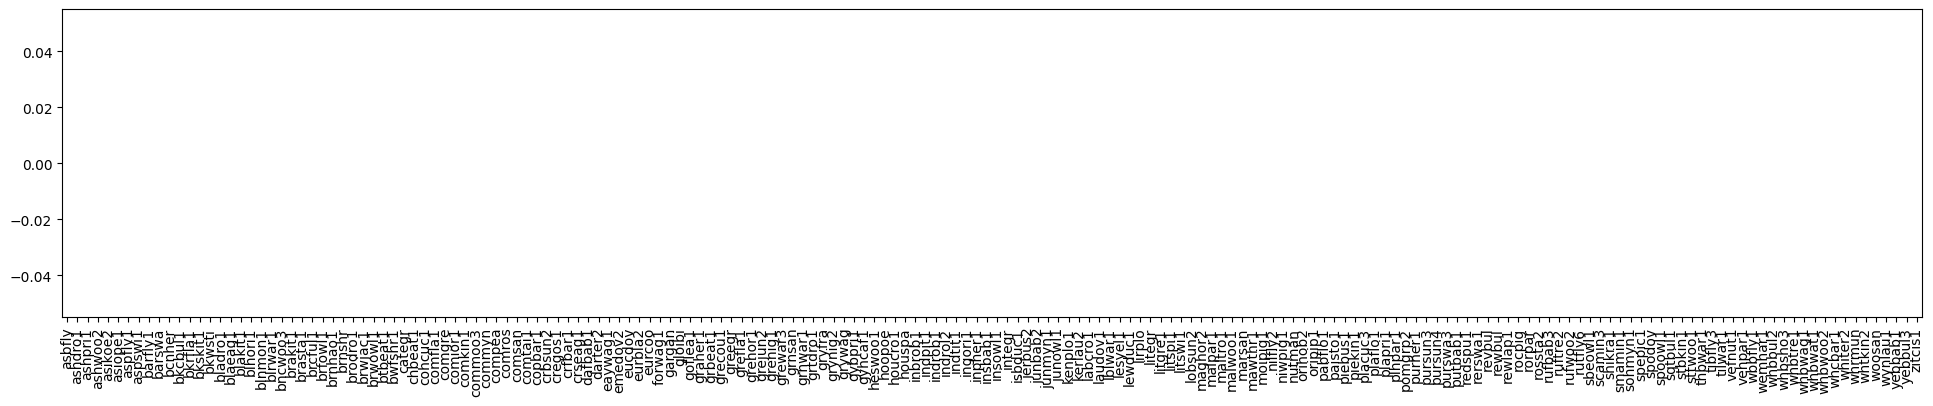

In [63]:
df[:48].set_index("row_id").max().T.plot(kind="bar", figsize=(24,4))

In [64]:
if KAGGLE == False:
    def get_fold_data(fold):
        
        valid = train_csv.loc[train_csv["fold"]==fold]
        filelist = [f"{cfg.dir}train_audio/{name}" for name in valid["filename"]]
    
        clearn_dataset = BirdCLEF_Dataset(df=filelist, augmentation=False, mode='clean')
        return clearn_dataset, valid

In [65]:
if KAGGLE == False:
    def predict_and_visualize(data_index):
        use_fold = 4
        c_dataset, df = get_fold_data(fold=use_fold)
        model = models[use_fold].to(device)
        
        prediction = model.forward(c_dataset[data_index][0].to(device)).cpu().detach()
        prediction = torch.sigmoid(prediction)
        
        df_index = df.index[data_index]
        true_labels = df.loc[df_index, "new_target"].split()
        true_guide_pos = [LABELS.index(l)+0.5 for l in true_labels]
    
        fig, ax = plt.subplots(figsize=(24, 1.5))
        sns.heatmap(prediction, cmap="jet", vmin=0, vmax=1)
        ax.set_xticks(np.arange(0,182))
        ax.set_xticklabels(LABELS, fontsize=8)
        
        ax.set_yticks(np.arange(0,prediction.shape[0]))
        ax.set_yticklabels(np.arange(1,1+prediction.shape[0])*5)
        
        for pos in true_guide_pos:
            ax.axvline(x=pos, color="red", ls="--", lw=0.9)
        
        plt.xticks(ticks=np.arange(0,182), labels=LABELS, color='black')  # 元の設定を保持
        plt.title(c_dataset[data_index][1])
        plt.show()

        return prediction

In [66]:
if KAGGLE == False:

    N = len(train_csv.loc[train_csv["fold"]==fold])//30
    print(N)
    
    predict_and_visualize(data_index=0)
    predict_and_visualize(data_index=1)
    predict_and_visualize(data_index=2)
    predict_and_visualize(data_index=3)
    predict_and_visualize(data_index=4)


    for i in range(N):
        try:
            predict_and_visualize(data_index=i*30)
        except:
            pass

In [67]:
if KAGGLE == False:
    model.eval().cuda();
    
    preds, trues, targets = [], [], []
    for idx, (data, label) in enumerate(tqdm(valid_dataloader, leave=False ,desc="[valid]")):
        data = data.to(device)
        label = label[0]
        # with amp.autocast(cfg.enable_amp):
        pred = model.forward(data[0].unsqueeze(1))
    
        preds.extend(pred.detach().cpu())
        trues.extend(label)
        targets.extend(label.argmax(axis=1))

    t = torch.stack(preds)
    targets = torch.tensor(targets)

    auc = multiclass_auroc(input=torch.sigmoid(t), target=targets, num_classes=len(LABELS),
                               average=None)

In [68]:
if KAGGLE == False:
    train_["primary_label"].value_counts().sort_index().plot(kind="bar", figsize=(20,4))
    plt.scatter(x=LABELS, y=auc*100, color="r")

In [69]:
if KAGGLE == False:
    train["primary_label"].value_counts().sort_index().plot(kind="bar", figsize=(20,4))
    plt.scatter(x=LABELS, y=auc*100, color="r")

In [70]:
if KAGGLE == False:
    valid["primary_label"].value_counts().sort_index().plot(kind="bar", figsize=(20,4))
    plt.scatter(x=LABELS, y=auc*100, color="r")

In [71]:
if KAGGLE == False:
    fig, axes = plt.subplots(figsize=(24,62), ncols=6, nrows=31, tight_layout=True)
    
    axs = axes.ravel()

    LABELS_COUNT = train_csv["primary_label"].value_counts().sort_index().to_numpy()
    LABELS_OCCUPY = train_csv["primary_label"].value_counts(normalize=True).sort_index().to_numpy()
    
    oof_predictions = torch.sigmoid(torch.stack(preds))
    oof_predictions = pd.DataFrame(oof_predictions, columns=LABELS)
    
    oof_predictions.head()
    
    oof_trues = torch.stack(trues)
    oof_trues = pd.DataFrame(oof_trues, columns=LABELS)
    
    oof_trues.head()
    LABEL_df = pd.DataFrame([LABELS,LABELS_COUNT]).T
    LABEL_df.columns = ["name", "count"]
    LABEL_df = LABEL_df.sort_values("count").reset_index(drop=True)
    iter = len(LABEL_df)
    
    for idx in range(iter):
        ax = axs[idx]
        
        l = LABEL_df.loc[idx, "name"]
        count = LABEL_df.loc[idx, "count"]
        
        tmp = pd.concat([oof_trues[f"{l}"], oof_predictions[f"{l}"]], axis=1)
        tmp.columns = ["label", f"{l}_prob"]
        
        tmp["10_label"] = (10*tmp["label"]).astype(int)
        
        sns.boxplot(tmp, x=f"{l}_prob", y="10_label",orient="h", width=0.5, ax=ax)
        ax.set(title=f"{l}_{count}", xlim=(0,1))
    

    
